In [2]:
import os
import csv
import pandas as pd
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

bbh_events = [
    'GW150914','GW151012','GW151226','GW170104','GW170608','GW170729',
    'GW170809','GW170814','GW170818','GW170823','GW190408_181802',
    'GW190412','GW190413_052954','GW190413_134308','GW190421_213856',
    'GW190424_180648','GW190425','GW190503_185404','GW190512_180714',
    'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544',
    'GW190521','GW190521_074359','GW190527_092055','GW190602_175927',
    'GW190620_030421','GW190630_185205','GW190701_203306','GW190706_222641',
    'GW190707_093326','GW190708_232457','GW190719_215514','GW190720_000836',
    'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701',
    'GW190814','GW190828_063405','GW190828_065509','GW190909_114149',
    'GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',
    'GW190930_133541'
]

output_dir = "./BBH/original-signals/"
#merged_csv = "./BBH/Original_BBH.csv"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    start = int(gps) - 15
    end = int(gps) + 15

    data = TimeSeries.fetch_open_data('L1', start, end)
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [03:46<00:00,  4.71s/it]


In [33]:
input_dir = "./BBH/original-signals/"
output_dir = "./BBH/processed-signals/"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    data = TimeSeries.read(input_dir + bbh_events[i]+".txt")
    data = data.whiten(4,2)
    data = data.bandpass(35, 350) 
    data = data.crop(gps - 2, gps + 2)
    data = data.taper('leftright', 0.5)
    data = data * 1e-21

    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

100%|██████████| 48/48 [00:17<00:00,  2.79it/s]


In [34]:
path = "./BBH/processed-signals/"
files= os.listdir(path)
f = open("./BBH/processed.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:02<00:00, 17.71it/s]


In [20]:
import os
import numpy as np
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# ========================================
# PARAMETERS
# ========================================
start, end = 1238166018, 1253977218  # O3a run start and end
detector = 'L1'
segment_duration = 30  # seconds (for download)
crop_duration = 4      # seconds (center crop for final use)
sample_rate = 4096
n_segments = 48        # Total number of noise segments desired

output_dir = "./BBH/original-noise-unseen/"
os.makedirs(output_dir, exist_ok=True)

np.random.seed(123)
start_times = np.random.randint(start, end - segment_duration, size=n_segments * 5)

downloaded = 0
for gps_start in tqdm(start_times, desc="Downloading unseen noise"):
    if downloaded >= n_segments:
        break
    try:
        ts = TimeSeries.fetch_open_data(detector, gps_start, gps_start + segment_duration, sample_rate=sample_rate)
        ts = ts.bandpass(35, 350)

        gps_center = gps_start + segment_duration // 2
        ts = ts.detrend('linear')
        ts = ts.crop(gps_center - crop_duration // 2, gps_center + crop_duration // 2)
        ts = ts.taper('leftright', 0.5)

        if len(ts) != sample_rate * crop_duration:
            continue

        ts.write(os.path.join(output_dir, f"noise_{downloaded}.txt"))
        downloaded += 1
    except Exception as e:
        continue

In [21]:
import csv
import pandas as pd

path = "./BBH/original-noise-unseen/"
files= os.listdir(path)
f = open("./BBH/original-noise-unseen.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:01<00:00, 32.09it/s]


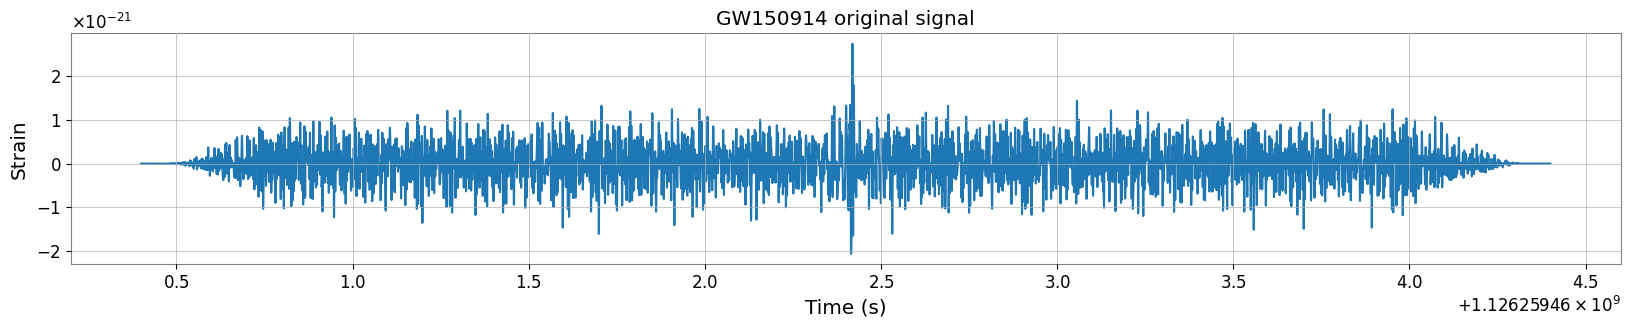

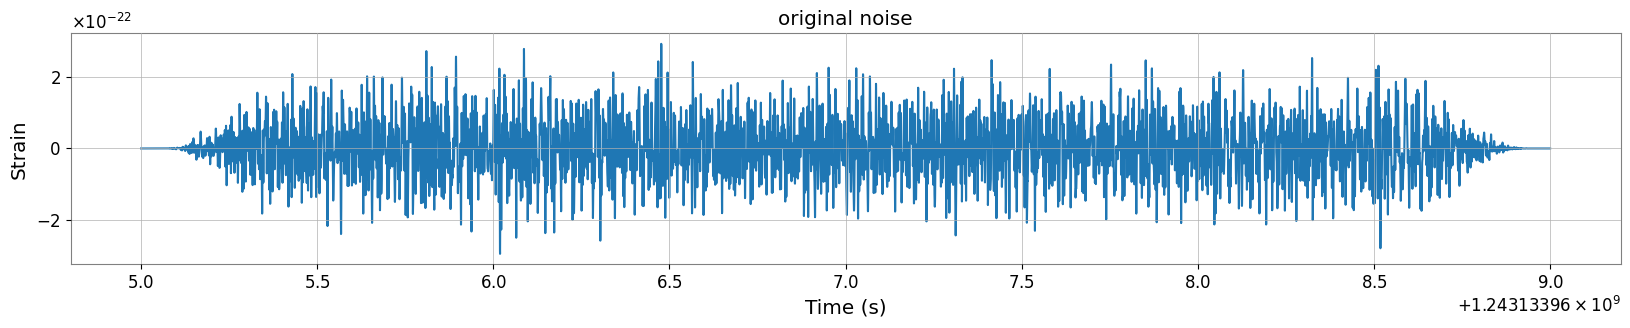

In [35]:
from gwpy.timeseries import TimeSeries as GTimeSeries
import matplotlib.pyplot as plt

ts = GTimeSeries.read('./BBH/processed-signals/GW150914.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("GW150914 original signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

ts = GTimeSeries.read('./BBH/original-noise-unseen/noise_0.txt')

plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("original noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()